In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.observations.ar_truncated_normal_observation import ARTruncatedNormalObservation
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from tqdm import tqdm_notebook as tqdm

import time

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from ssm.hmm import HMM as ssm_HMM

test truncated normal

# generate synthetic data

generate data with similar dynamics

In [49]:
K = 3
D = 2
T = 200

In [30]:
torch.manual_seed(0)
npr.seed(0)

As = [random_rotation(D) for _ in range(K)]
bounds = np.array([[0,10], [0,10]])
thetas = np.linspace(0, 2 * np.pi, K, endpoint=False)
mus_init = 3 * np.column_stack((np.cos(thetas), np.sin(thetas))) + 5

In [33]:
true_tran = LinearTransformation(K=K, D=D, lags=1, As=As)
true_observation = ARTruncatedNormalObservation(K=K, D=D, M=0, lags=1, transformation=true_tran, bounds=bounds, mus_init=mus_init)
true_model = HMM(K=K, D=D, M=0, observation=true_observation)

In [34]:
z, x = true_model.sample(T, return_np=False)
true_ll = true_model.log_likelihood(x)

In [35]:
true_ll

tensor(-299.2986, dtype=torch.float64, grad_fn=<HMMNormalizerCythonBackward>)

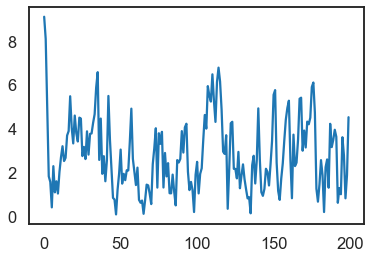

In [36]:
plt.plot(x[:,1].numpy())

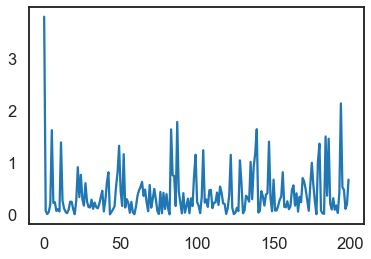

In [37]:
plt.plot(x[:,0].numpy())

([], <a list of 0 Text yticklabel objects>)

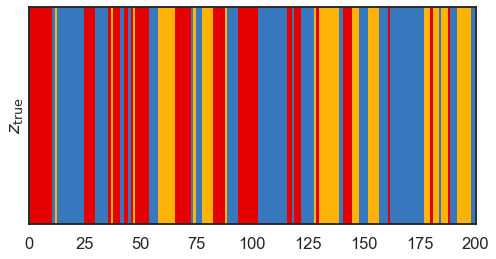

In [38]:
plt.figure(figsize=(8, 4))
plt.imshow(z[None,:].numpy(), aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])


learning

In [39]:
tran = LinearTransformation(K=K, D=D, lags=1, As=As)
observation = ARTruncatedNormalObservation(K=K, D=D, M=0, lags=1, transformation=tran, bounds=bounds, mus_init=mus_init)
model = HMM(K=K, D=D, M=0, observation=true_observation)

In [40]:
num_iters = 10000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(x)    
    loss.backward()
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

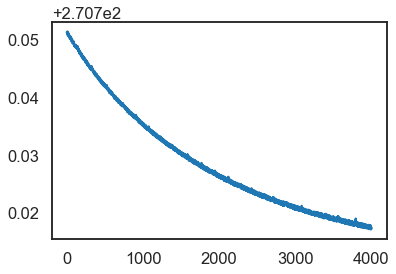

In [55]:
plt.plot(losses[6000:])

infer hidden states

In [42]:
infer_z = model.most_likely_states(x)

perm = find_permutation(z.numpy(), infer_z, K1=K, K2=K)

model.permute(perm)
infer_z = model.most_likely_states(x)

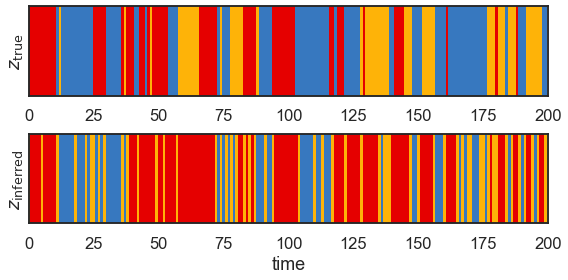

In [43]:
# Plot the true and inferred discrete states

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(infer_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [44]:
true_model.transition_matrix

tensor([[0.7910, 0.1048, 0.1042],
        [0.1043, 0.7904, 0.1053],
        [0.1066, 0.1037, 0.7897]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

In [45]:
model.transition_matrix

tensor([[4.8244e-01, 3.4524e-04, 5.1722e-01],
        [9.7437e-04, 7.1080e-01, 2.8823e-01],
        [4.4978e-01, 3.8735e-01, 1.6287e-01]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

check prediction

In [46]:
x_predict_cond_z = k_step_prediction(model, z, x)
x_predict_cond_most_likely_z = k_step_prediction(model, infer_z, x)

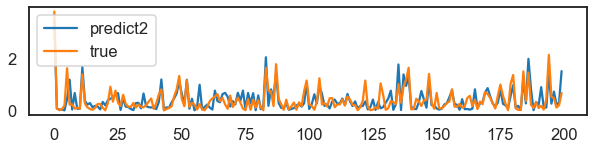

In [47]:
plt.figure(figsize=(10,2))
#plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,0], label='predict2')
plt.plot(x[:,0].numpy(), label='true')
plt.legend()

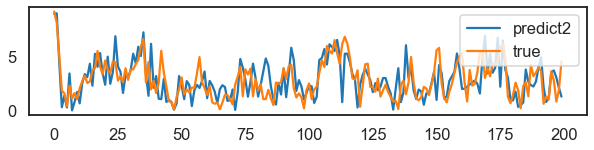

In [48]:
plt.figure(figsize=(10,2))
#plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,1], label='predict2')
plt.plot(x[:,1].numpy(), label='true')
plt.legend()

# dive into the true model

Text(0.5, 1.0, 'x2')

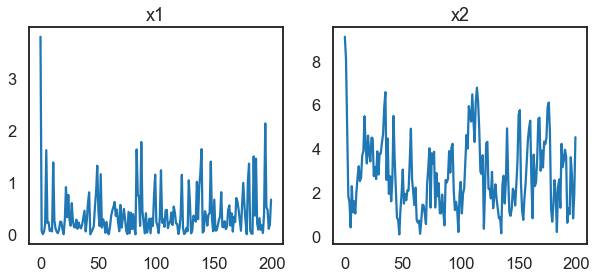

In [57]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x[:,0].numpy())
plt.title("x1")

plt.subplot(1,2,2)
plt.plot(x[:,1].numpy())
plt.title("x2")

In [52]:
bounds

array([[ 0, 10],
       [ 0, 10]])